<a href="https://colab.research.google.com/github/mikeyny/demos/blob/main/examples/Virtual_Try_On.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Virtual Try-On with Gemini 2.5 & Imagen 3

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Virtual_Try_On.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>


This notebook is an implementation of virtually trying on different outfits by image editing and inpainting using Imagen 3, along with Gemini 2.5 for creating segmentation masks.

>**Note:** This notebook is designed to run on Google Colab. Certain commands, such as `%cd`, are specific to the Colab environment and may not work outside of it.


#### Developed by [Nitin Tiwari](https://linkedin.com/in/tiwari-nitin).

>**Note:** For the older implementation that used SAM 2.1 to generate segmentation masks, refer to this [notebook](https://github.com/NSTiwari/Virtual-Try-On-Imagen3/blob/main/Virtual_Try_On_Imagen3.ipynb).

## Before you begin

Before starting, ensure you have the following prerequisites in place:

* **Gemini API Access:** Make sure you have access to the Gemini API.

* **GCP Account:** You’ll need an active GCP account with a billing project set up and the Vertex AI API enabled. If you’re unsure how to get started, follow the instructions in this setup [guide](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).


Once you have these ready, you're good to go.

## Step 1: Install Gen AI SDK

In [2]:
%pip install -U -q google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 7.8 MB/s eta 0:00:00


## Step 2: Import libraries

In [3]:
import cv2
import numpy as np
from PIL import Image as PILImage
from matplotlib import pyplot as plt
from google import genai
from google.genai import types
import random
import base64
from IPython.display import Markdown, HTML
from base64 import b64encode
import json
import io
from io import BytesIO

from google.colab import userdata, auth
auth.authenticate_user()

import vertexai
from vertexai.preview.vision_models import (
    ControlReferenceImage,
    Image,
    ImageGenerationModel,
    MaskReferenceImage,
    RawReferenceImage,
)

## Step 3: Configure Gemini API key and GCP Project ID

To run the following cell, your Gemini API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

Additionally, please also store your GCP Project ID in a Colab Secret named `GCP_PROJECT_ID`.

In [11]:
# Comfigure Gemini API key.
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GEMINI_API_KEY)

# Configure GCP Project ID for Vertex AI.
GCP_PROJECT_ID = userdata.get('GCP_PROJECT_ID')

# Configure model.
MODEL_ID = "gemini-2.5-flash-preview-04-17" # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-05-06"] {"allow-input":true}

#### System Instructions

In [5]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
"""

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

In [15]:
def parse_json(text: str) -> str:
    return text.strip().removeprefix("```json").removesuffix("```")

"""
Function adapted from:
https://github.com/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb
"""
def generate_mask(predicted_str: str, *, img_height: int, img_width: int) -> list[tuple[np.ndarray, str]]:
    try:
        items = json.loads(parse_json(predicted_str))
        if not isinstance(items, list):
            print("Error: Parsed JSON is not a list.")
            return []
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        print(f"Problematic string snippet: {predicted_str[:200]}...")
        return []
    except Exception as e:
        print(f"An unexpected error occurred during JSON parsing: {e}")
        return []

    segmentation_data = []
    default_label = "unknown"

    for item_idx, item in enumerate(items):
        if not isinstance(item, dict) or "box_2d" not in item or "mask" not in item:
            print(f"Skipping invalid item structure at index {item_idx}: {item}")
            continue

        label = item.get("label", default_label)
        if not isinstance(label, str) or not label:
            label = default_label

        png_str = item["mask"]
        if not isinstance(png_str, str) or not png_str.startswith("data:image/png;base64,"):
            print(f"Skipping item {item_idx} (label: {label}) with invalid mask format.")
            continue
        png_str = png_str.removeprefix("data:image/png;base64,")
        try:
            png_bytes = base64.b64decode(png_str)
            bbox_mask = cv2.imdecode(np.frombuffer(png_bytes, np.uint8), cv2.IMREAD_GRAYSCALE)
            if bbox_mask is None:
                print(f"Skipping item {item_idx} (label: {label}) because mask decoding failed.")
                continue
        except (base64.binascii.Error, ValueError, Exception) as e:
            print(f"Error decoding base64 or image data for item {item_idx} (label: {label}): {e}")
            continue

        try:
            box = item["box_2d"]
            if not isinstance(box, list) or len(box) != 4:
                print(f"Skipping item {item_idx} (label: {label}) with invalid box_2d format: {box}")
                continue
            y0_norm, x0_norm, y1_norm, x1_norm = map(float, box)
            abs_y0 = max(0, min(int(y0_norm / 1000.0 * img_height), img_height - 1))
            abs_x0 = max(0, min(int(x0_norm / 1000.0 * img_width), img_width - 1))
            abs_y1 = max(0, min(int(y1_norm / 1000.0 * img_height), img_height))
            abs_x1 = max(0, min(int(x1_norm / 1000.0 * img_width), img_width))
            bbox_height = abs_y1 - abs_y0
            bbox_width = abs_x1 - abs_x0
            if bbox_height <= 0 or bbox_width <= 0:
                print(f"Skipping item {item_idx} (label: {label}) with invalid bbox dims: {box} -> ({bbox_width}x{bbox_height})")
                continue
        except (ValueError, TypeError) as e:
            print(f"Skipping item {item_idx} (label: {label}) due to error processing box_2d: {e}")
            continue

        try:
            if bbox_mask.shape[0] > 0 and bbox_mask.shape[1] > 0:
                resized_bbox_mask = cv2.resize(
                    bbox_mask, (bbox_width, bbox_height), interpolation=cv2.INTER_LINEAR
                )
            else:
                print(f"Skipping item {item_idx} (label: {label}) due to empty decoded mask before resize.")
                continue
        except cv2.error as e:
            print(f"Error resizing mask for item {item_idx} (label: {label}): {e}")
            continue

        full_mask = np.zeros((img_height, img_width), dtype=np.uint8)  # Start with a black mask (0s)
        try:
            full_mask[abs_y0:abs_y1, abs_x0:abs_x1] = resized_bbox_mask  # Place the white mask in the right location
        except ValueError as e:
            print(f"Error placing mask for item {item_idx} (label: {label}): {e}. Shape mismatch: slice=({bbox_height},{bbox_width}), resized={resized_bbox_mask.shape}. Attempting correction.")
            try:
                resized_bbox_mask_corrected = cv2.resize(bbox_mask, (bbox_width, bbox_height), interpolation=cv2.INTER_LINEAR)
                full_mask[abs_y0:abs_y1, abs_x0:abs_x1] = resized_bbox_mask_corrected
                print("  -> Corrected placement.")
            except Exception as inner_e:
                print(f"  -> Failed to correct placement: {inner_e}")
                continue

        segmentation_data.append((full_mask, label))

    return segmentation_data


"""
Function adapted from:
https://github.com/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb
"""
# def create_binary_mask_overlay(
#     img: PILImage.Image,
#     segmentation_data: list[tuple[np.ndarray, str]],
#     alpha: float = 0.8
# ) -> np.ndarray:

#     binary_mask = np.zeros(img.size[::-1], dtype=np.uint8)

#     for mask, label in segmentation_data:
#         if mask is not None and mask.shape == binary_mask.shape:
#             binary_mask = np.maximum(binary_mask, mask)

#     result = np.zeros_like(binary_mask, dtype=np.uint8)
#     result[binary_mask > 0] = 255

#     return result

from typing import List, Tuple
import numpy as np
from PIL import Image as PILImage

def create_binary_mask_overlay(
    img: PILImage.Image,
    segmentation_data: List[Tuple[np.ndarray, str]],
    alpha: float = 0.8
) -> PILImage.Image:
    """
    Return the original image with an alpha‑channel in which every pixel that
    belongs to *any* segmentation mask is fully transparent (alpha = 0) and
    every other pixel gets the opacity specified by `alpha`.

    Parameters
    ----------
    img : PIL.Image
        The source image.
    segmentation_data : list[tuple[np.ndarray, str]]
        Each tuple is (mask_array, label).  `mask_array` must be a 2‑D binary
        array (True / 1 == ‘belongs to object’).  `label` is ignored here.
    alpha : float, default 0.8
        Global opacity (0–1) for pixels *outside* the masks.

    Returns
    -------
    PIL.Image
        The RGBA image with transparent cut‑outs over segmentation regions.
    """
    # --- Prepare image & alpha mask ------------------------------------------------
    rgba = img.convert("RGBA")
    height, width = rgba.height, rgba.width

    # Start with everything opaque at the requested alpha level
    alpha_val = int(round(255 * np.clip(alpha, 0.0, 1.0)))
    alpha_mask = np.full((height, width), alpha_val, dtype=np.uint8)

    # --- Carve out transparent areas ---------------------------------------------
    for seg_mask, _ in segmentation_data:
        if seg_mask is None:
            continue
        if seg_mask.shape != (height, width):
            raise ValueError(
                f"Mask shape {seg_mask.shape} does not match image shape {(height, width)}"
            )

        # Make sure we have a boolean mask
        seg_bool = seg_mask.astype(bool)
        # Set alpha to 0 (fully transparent) where the object is
        alpha_mask[seg_bool] = 0

    # --- Attach the alpha channel & return ---------------------------------------
    rgba.putalpha(PILImage.fromarray(alpha_mask, mode="L"))
    return rgba


## Step 4: Referring Expression Segmentation by Gemini 2.5

Pass the image, and the object to be segmented as part of the text prompt to Gemini 2.5.

In [7]:
# Get a sample image.
!wget -q https://storage.googleapis.com/generativeai-downloads/images/Virtual_try_on_person.png -O /content/image_01.png

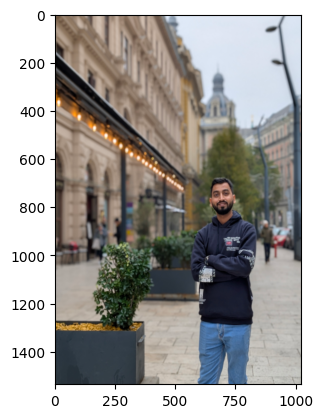

In [10]:
# prompt: convert the image to 1024 x 1536

import matplotlib.pyplot as plt
def resize_image(image_path, new_width=1024, new_height=1536):
    """Resizes an image to the specified dimensions.

    Args:
        image_path: Path to the image file.
        new_width:  The desired width of the resized image.
        new_height: The desired height of the resized image.

    Returns:
        A NumPy array representing the resized image, or None if an error occurs.
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not open or read image at {image_path}")
            return None

        resized_img = cv2.resize(img, (new_width, new_height))
        return resized_img

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

input_image = 'image_01.png'
# Example usage (assuming you have an image file named 'input.jpg'):
resized_image = resize_image(f"/content/{input_image}")

if resized_image is not None:
    # Display the resized image (optional)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Save the resized image (optional)
    cv2.imwrite(input_image, resized_image)




In [18]:
input_image = 'image_01.png' # @param {type : 'string'}
object_to_segment = 'hoodie' # @param {type: 'string'}

prompt = f"Give the segmentation masks for {object_to_segment}. Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key 'box_2d', the segmentation mask in key 'mask', and the text label in the key 'label'."

image_path = f"/content/{input_image}"
img = PILImage.open(image_path)

# Run model and generate segmentation masks.
img_height, img_width = img.size[1], img.size[0]
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, img],
    config=types.GenerateContentConfig(
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

result = response.text
segmentation_data = generate_mask(result, img_height=img_height, img_width=img_width)

# Create binary mask overlay.
if segmentation_data:
    binary_mask = create_binary_mask_overlay(img, segmentation_data, alpha=0.8)
    binary_mask.save(f"annotation_mask_{input_image}")
else:
    print("No segmentation mask found.")

img_array = np.array(img)
overlay_np = np.array(binary_mask)
binary_array  = cv2.cvtColor(overlay_np, cv2.COLOR_RGBA2BGRA)

binary_array_3d = np.expand_dims(binary_array, axis=2)
binary_array_3d = np.repeat(binary_array_3d, 3, axis=2)

gap_width = 20
empty_img = np.full((img_array.shape[0], gap_width, img_array.shape[2]), 255, dtype=img_array.dtype)
combined_image = np.hstack((img_array, empty_img, binary_array_3d))

fig, axes = plt.subplots(1, 1, figsize=(img_array.shape[1] / 50, img_array.shape[0] / 50))

axes.imshow(combined_image)
axes.axis('off')

plt.show()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 2 has 4 dimension(s)

## Step 5: Configure Imagen 3 parameters

Next, certain parameters need to be configured as follows:

* `Base image`: The input image file to be edited.
* `Mask file:`: The binary mask of the object to be inpainted.
* `Edit mode`: Options like inpainting-insert, inpainting-remove, or outpainting.
* `Mask mode`: Background or foreground
* `Dilation`: A float value between 0 and 1 indicating the percentage of the provided mask.

In [19]:
mask_file = f"/content/annotation_mask_{input_image}"
output_file = f"/content/output_{input_image}"
prompt = "A dark green jacket, white shirt inside it" # @param {type: 'string'}

edit_mode = 'inpainting-insert' # @param ['inpainting-insert', 'outpainting', 'inpainting-remove']
mask_mode = 'foreground' # @param ['foreground', 'background']
dilation = 0.01 # @param {type:"slider", min:0, max:1, step:0.01}

## Step 6: Generate and inpaint new image using Imagen 3

Finally, the image is ready to be generated and edited using Imagen 3.

>**Note:** For accurate image generation and editing, ensure a precise mask of the object is provided. Additionally, a detailed prompt should be given for the image to be generated. Achieving optimal results may require several attempts.

In [20]:
vertexai.init(project=GCP_PROJECT_ID, location="us-central1")

edit_model = ImageGenerationModel.from_pretrained("imagen-3.0-capability-001")

base_img = Image.load_from_file(location=image_path)
mask_img = Image.load_from_file(location=mask_file)

raw_ref_image = RawReferenceImage(image=base_img, reference_id=0)
mask_ref_image = MaskReferenceImage(
    reference_id=1, image=mask_img, mask_mode=mask_mode, dilation=dilation
)

edited_image = edit_model.edit_image(
    prompt=prompt,
    edit_mode=edit_mode,
    reference_images=[raw_ref_image, mask_ref_image],
    number_of_images=1,
    safety_filter_level="block_some",
    person_generation="allow_adult",
)

edited_image[0].save(output_file)

NotFound: 404 Image editing failed with the following error: imagen-3.0-capability-001 is unavailable.

Congratulations on successfully completing this tutorial and building a Virtual Try-On application using Gemini 2.5's segmentation and Imagen 3's powerful image generation capabilities.

In [23]:
from openai import OpenAI
client = OpenAI(api_key=userdata.get("OPEN_API_KEY"))

mask_file = f"/content/annotation_mask_{input_image}"
output_file = f"/content/output_{input_image}"
prompt = "A dark green jacket, white shirt inside it"
result = client.images.edit(
      model="gpt-image-1",
    image=open(image_path, "rb"),
    mask=open(mask_file, "rb"),
    prompt=prompt,
    n=1,
    size="1024x1536",
)

image_base64 = result.data[0].b64_json
image_bytes = base64.b64decode(image_base64)

# Save the image to a file
with open(output_file, "wb") as f:
    f.write(image_bytes)

None


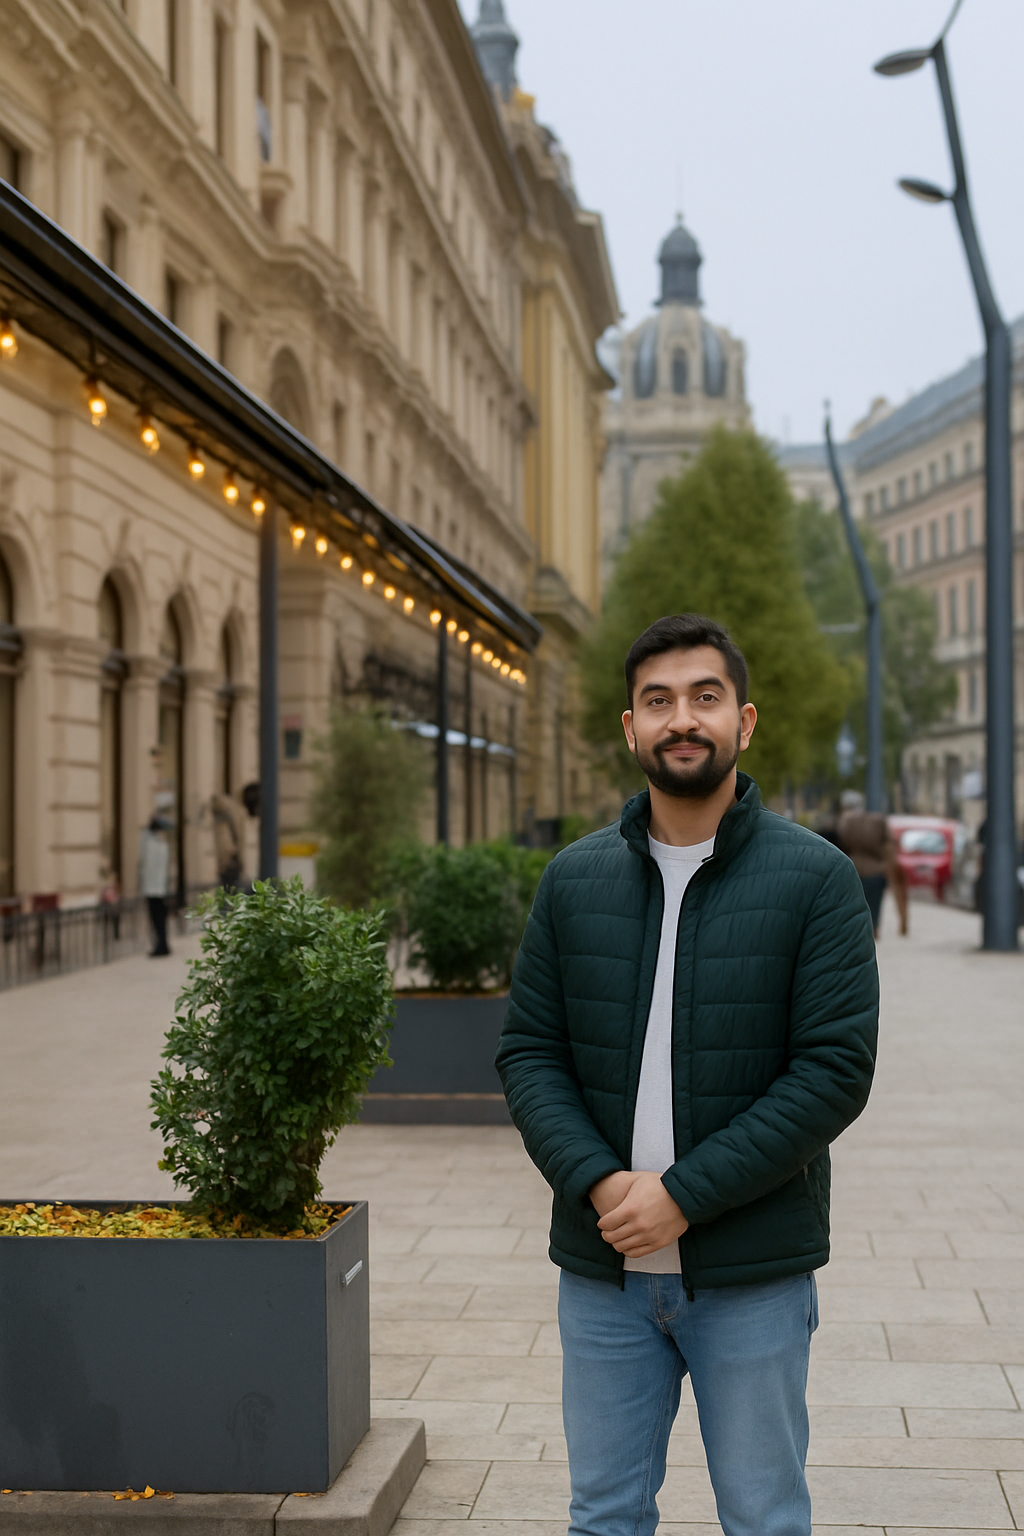

In [26]:
output_file = PILImage.open('/content/output_image_01.png')
display(output_file)